<table style="font-size: 1em; padding: 0; margin: 0;">
<p style="border: 1px solid #ff5733; border-left: 15px solid #ff5733; padding: 10px; text-align:justify;">
    <strong style="color: #ff5733">Deliverable</strong>  
    <br/>The deliverable for Part 5 is a jupyter notebook showing a workflow to optimize the training of a model using the NWPU-RESISC45 lake images and corresponding labels, for the purposes of estimating lake area over time at sites represented in the Sentinel-2 imagery. The notebook will also show how to refine image labels based on a CRF model using both image color and relative spatial location in the image to make predictions, using optimized tunable parameters. This will mostly test your understanding of the generic yet complex workflow of optimizing model training, and applying a model trained on one dataset to another similar dataset, for the operational purpose of developing a time-series of lake areas at critical sites. 
    </p>

In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import json, os
import matplotlib
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Activation, Add
from tensorflow.keras.layers import Concatenate, Conv2DTranspose, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from random import shuffle
from PIL import Image
from pydensecrf import densecrf
from pydensecrf.utils import unary_from_labels

In [3]:
def batchnorm_act(x):
    x = BatchNormalization()(x)
    return Activation("relu")(x)

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = batchnorm_act(x)
    return Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)

def bottleneck_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([conv, bottleneck])

def res_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([bottleneck, res])

def upsamp_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    return Concatenate()([u, xskip])

def res_unet(sz, f):
    inputs = Input(sz)
    
    ## downsample  
    e1 = bottleneck_block(inputs, f); f = int(f*2)
    e2 = res_block(e1, f, strides=2); f = int(f*2)
    e3 = res_block(e2, f, strides=2); f = int(f*2)
    e4 = res_block(e3, f, strides=2); f = int(f*2)
    _ = res_block(e4, f, strides=2)
    
    ## bottleneck
    b0 = conv_block(_, f, strides=1)
    _ = conv_block(b0, f, strides=1)
    
    ## upsample
    _ = upsamp_concat_block(_, e4)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e3)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e2)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e1)
    _ = res_block(_, f)
    
    ## classify
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(_)
    
    #model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [4]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [5]:
def crf_labelrefine(input_image, predicted_labels):
    
    compat_spat=10
    compat_col=30
    theta_spat = 20
    theta_col = 80
    num_iter = 7
    
    h, w = input_image.shape[:2] #get image dimensions
    
    d = densecrf.DenseCRF2D(w, h, 2) #create a CRF object

    # For the predictions, densecrf needs 'unary potentials' which are labels (water or no water)
    num_classes=2
    predicted_unary = unary_from_labels(predicted_labels.astype('int')+1, num_classes, gt_prob= 0.51)
    
    # set the unary potentials to CRF object
    d.setUnaryEnergy(predicted_unary)

    # to add the color-independent term, where features are the locations only:
    d.addPairwiseGaussian(sxy=(theta_spat, theta_spat), compat=compat_spat, kernel=densecrf.DIAG_KERNEL,
                          normalization=densecrf.NORMALIZE_SYMMETRIC)

    input_image_uint = (input_image * 255).astype(np.uint8) #enfore unsigned 8-bit
    # to add the color-dependent term, i.e. 5-dimensional features are (x,y,r,g,b) based on the input image:    
    d.addPairwiseBilateral(sxy=(theta_col, theta_col), srgb=(5, 5, 5), rgbim=input_image_uint,
                           compat=compat_col, kernel=densecrf.DIAG_KERNEL, 
                           normalization=densecrf.NORMALIZE_SYMMETRIC)

    # Finally, we run inference to obtain the refined predictions:
    refined_predictions = np.array(d.inference(num_iter)).reshape(num_classes, h, w)
    
    # since refined_predictions will be a 2 x width x height array, 
    # each slice respresenting probability of each class (water and no water)
    # therefore we return the argmax over the zeroth dimension to return a mask
    return np.argmax(refined_predictions,axis=0)

In [6]:
def image_batch_generator(files, batch_size = 32, sz = (512, 512)):
  
  while True: # this is here because it will be called repeatedly by the training function
    
    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []
    
    #cycle through each image in the batch
    for f in batch:

        #preprocess the raw images 
        rawfile = f'nwpu_images/data/{f}'
        raw = Image.open(rawfile)
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]
            
        #get the image dimensions, find the min dimension, then square the image off    
        nx, ny, nz = np.shape(raw)
        n = np.minimum(nx,ny)
        raw = raw[:n,:n,:] 
            
        batch_x.append(raw)
        
        #get the masks. 
        maskfile = rawfile.replace('nwpu_images','nwpu_label_images')+'_mask.jpg'
        mask = Image.open(maskfile)
        # the mask is 3-dimensional so get the max in each channel to flatten to 2D
        mask = np.max(np.array(mask.resize(sz)),axis=2)
        # water pixels are always greater than 100
        mask = (mask>200).astype('int')
        
        mask = mask[:n,:n]
        
        # use CRF to refine mask before it is used as a label
        mask = crf_labelrefine(raw, mask).squeeze()

        batch_y.append(mask)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255. #divide image by 255 to normalize
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

In [7]:
# inheritance for training process plot 
class PlotLearning(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'dice_coef=',logs.get('dice_coef'),'val_dice_coef=',logs.get('val_dice_coef'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        infile = f'nwpu_images/data/{path}'
        raw = Image.open(infile)
        raw = np.array(raw.resize((512, 512)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = 255*model.predict(np.expand_dims(raw, 0)).squeeze()
        print(np.max(pred))
                
        #mask post-processing 
        msk  = (pred>60).astype('int') #100    
        
        # use CRF to refine mask before it is used as a label
        msk = crf_labelrefine(raw, msk).squeeze()
      
        msk = np.stack((msk,)*3, axis=-1)
          
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()      

In [8]:
def build_callbacks(filepath, min_delta, min_lr, factor):

    earlystop = EarlyStopping(monitor="val_loss", 
                                  mode="min", patience=5) 
    
    # reduction of learning rate if and when validation scores plateau upon successive epochs
    reduceloss_plat = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=5, 
                                    verbose=1, mode='auto', min_delta=min_delta, 
                                    cooldown=5, min_lr=min_lr)

    # set checkpoint file 
    model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                                   verbose=0, save_best_only=True, mode='min', 
                                   save_weights_only = True)
        
    callbacks = [model_checkpoint, reduceloss_plat, earlystop, PlotLearning()]

    return callbacks 

In [9]:
model = res_unet((512, 512, 3), 16)  #32
model.compile(optimizer = 'rmsprop', loss = dice_coef_loss, metrics = [dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 16) 64          input_1[0][0]                    
______________________________________________________________________________________________

21
14
  ...
    to  
  ['...']
  ...
    to  
  ['...']
i= 1 loss= 0.3717192808787028 val_loss= 0.7253745070525578 dice_coef= 0.6282807 val_dice_coef= 0.27462548
103.014175


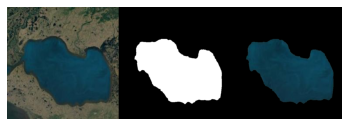

i= 2 loss= 0.35875427439099267 val_loss= 0.6027789413928986 dice_coef= 0.6412457 val_dice_coef= 0.39722106
255.0


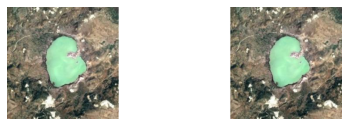

i= 3 loss= 0.23716801121121361 val_loss= 0.9485802778175899 dice_coef= 0.762832 val_dice_coef= 0.051419728
24.079733


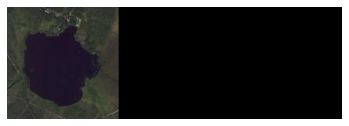

i= 4 loss= 0.24284557785306657 val_loss= 0.9916417683873858 dice_coef= 0.7571545 val_dice_coef= 0.008358231
12.3855295


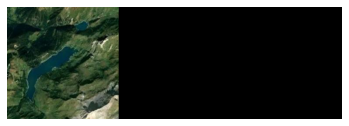

i= 5 loss= 0.18778064705076672 val_loss= 0.9994743977274213 dice_coef= 0.81221926 val_dice_coef= 0.00052559323
6.4881115


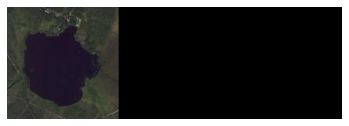

i= 6 loss= 0.2450940722510928 val_loss= 0.9733781303678241 dice_coef= 0.7549059 val_dice_coef= 0.02662186
254.99841


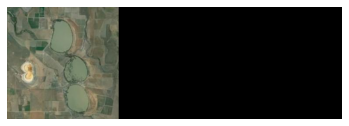


Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
i= 7 loss= 0.290676786786034 val_loss= 0.6234512329101562 dice_coef= 0.7093232 val_dice_coef= 0.3765488
255.0


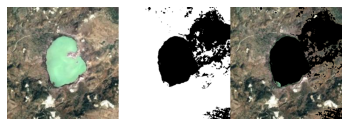

i= 8 loss= 0.1811834488596235 val_loss= 0.5689348408154079 dice_coef= 0.8188166 val_dice_coef= 0.43106514
255.0


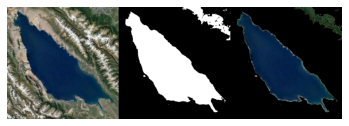

i= 9 loss= 0.2175871275720142 val_loss= 0.6015316418239048 dice_coef= 0.7824128 val_dice_coef= 0.39846835
254.99767


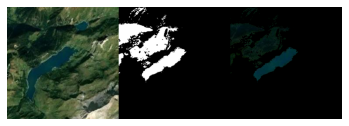

i= 10 loss= 0.18166052727472215 val_loss= 0.9999851754733494 dice_coef= 0.8183394 val_dice_coef= 1.4825324e-05
0.30936575


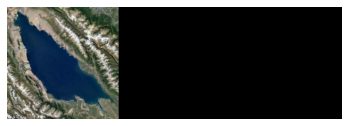

i= 11 loss= 0.2076152619861421 val_loss= 0.9746792827333722 dice_coef= 0.79238474 val_dice_coef= 0.02532072
0.23211592


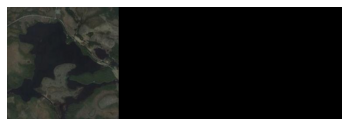

i= 12 loss= 0.21148142644337245 val_loss= 0.9742996905531202 dice_coef= 0.7885186 val_dice_coef= 0.025700303
0.10371944


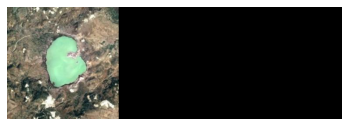

i= 13 loss= 0.2888516216051011 val_loss= 0.9246091416903904 dice_coef= 0.71114844 val_dice_coef= 0.07539086
0.23963353


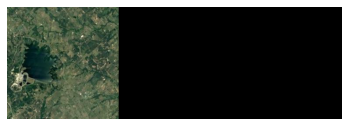

i= 14 loss= 0.19861454906917753 val_loss= 0.7118756175041199 dice_coef= 0.8013854 val_dice_coef= 0.28812438
0.1655026


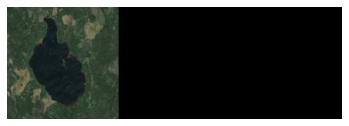

i= 15 loss= 0.14153349683398292 val_loss= 0.8579564648015159 dice_coef= 0.85846645 val_dice_coef= 0.14204353
0.14123559


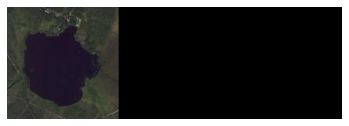


Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
i= 16 loss= 0.1817615713391985 val_loss= 0.6642245267118726 dice_coef= 0.8182384 val_dice_coef= 0.33577546
0.052665036


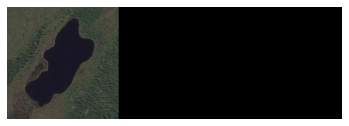

i= 17 loss= 0.175961020446959 val_loss= 0.5818379989692143 dice_coef= 0.8240389 val_dice_coef= 0.41816196
0.07284721


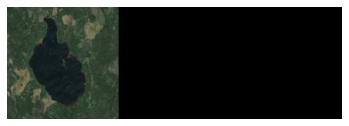

i= 18 loss= 0.21478040729250228 val_loss= 0.8369587702410561 dice_coef= 0.7852195 val_dice_coef= 0.16304122
0.049733132


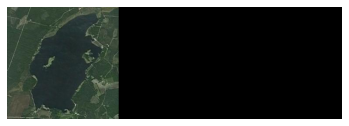

i= 19 loss= 0.17530039094743274 val_loss= 0.4236072472163609 dice_coef= 0.8246996 val_dice_coef= 0.5763927
255.0


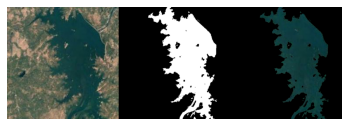

i= 20 loss= 0.11371558336984544 val_loss= 0.2909624832017081 dice_coef= 0.8862844 val_dice_coef= 0.7090375
255.0


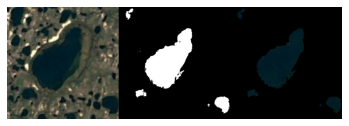

i= 21 loss= 0.14246877886000134 val_loss= 0.40289735794067383 dice_coef= 0.85753113 val_dice_coef= 0.59710264
254.94493


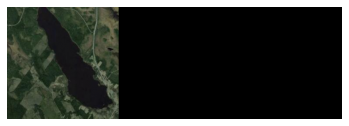

i= 22 loss= 0.21777750764574325 val_loss= 0.3529613869530814 dice_coef= 0.78222257 val_dice_coef= 0.6470386
254.99945


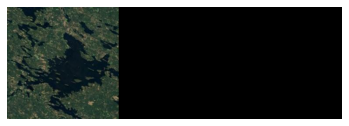

i= 23 loss= 0.18175489845730008 val_loss= 0.1796953252383641 dice_coef= 0.8182451 val_dice_coef= 0.82030475
255.0


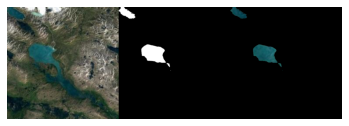

i= 24 loss= 0.30278741178058444 val_loss= 0.2969193628856114 dice_coef= 0.6972126 val_dice_coef= 0.70308053
0.0883416


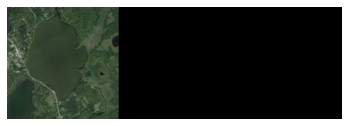

i= 25 loss= 0.13584801128932408 val_loss= 0.2850479313305446 dice_coef= 0.864152 val_dice_coef= 0.71495205
255.0


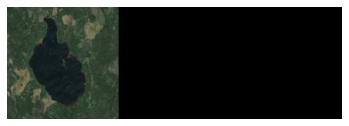

i= 26 loss= 0.17141547941026233 val_loss= 0.1796852137361254 dice_coef= 0.82858455 val_dice_coef= 0.82031494
255.0


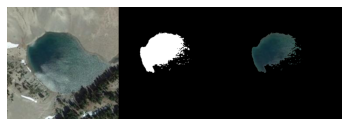

i= 27 loss= 0.16015262263161795 val_loss= 0.1447364858218602 dice_coef= 0.8398474 val_dice_coef= 0.8552636
255.0


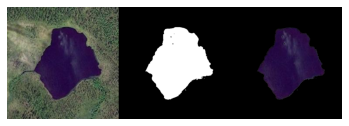

i= 28 loss= 0.16059414545694986 val_loss= 0.18899638312203543 dice_coef= 0.8394059 val_dice_coef= 0.8110037
255.0


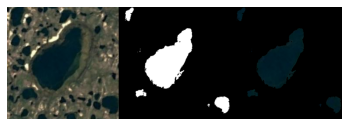

i= 29 loss= 0.16671670902343022 val_loss= 0.26449024251529146 dice_coef= 0.83328336 val_dice_coef= 0.7355097
255.0


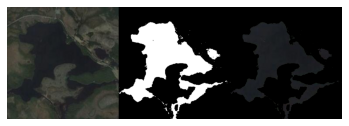

i= 30 loss= 0.09951099043800718 val_loss= 0.21870602880205428 dice_coef= 0.900489 val_dice_coef= 0.78129405
255.0


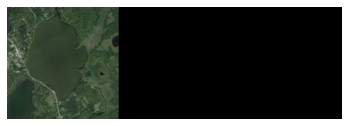

i= 31 loss= 0.17744032825742448 val_loss= 0.35086902550288607 dice_coef= 0.82255965 val_dice_coef= 0.64913094
255.0


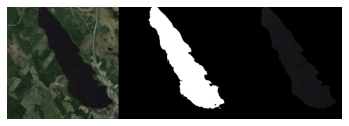


Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.
i= 32 loss= 0.12309271097183228 val_loss= 0.29668200441769194 dice_coef= 0.8769072 val_dice_coef= 0.703318
0.009959693


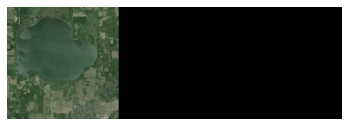

i= 33 loss= 0.16956588483992077 val_loss= 0.1685772623334612 dice_coef= 0.8304341 val_dice_coef= 0.83142275
255.0


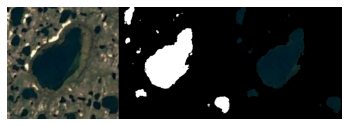

i= 34 loss= 0.16364003930773055 val_loss= 0.20288804173469543 dice_coef= 0.83636004 val_dice_coef= 0.7971119
255.0


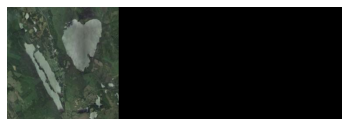

i= 35 loss= 0.1140248349734715 val_loss= 0.25252183420317514 dice_coef= 0.8859752 val_dice_coef= 0.7474782
255.0


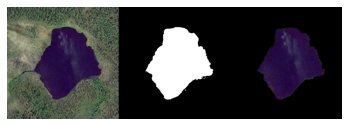

i= 36 loss= 0.22538729508717856 val_loss= 0.1980755158833095 dice_coef= 0.7746127 val_dice_coef= 0.8019245
255.0


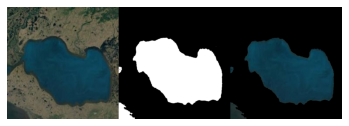

i= 37 loss= 0.10028562375477382 val_loss= 0.2209628905568804 dice_coef= 0.8997144 val_dice_coef= 0.77903706
255.0


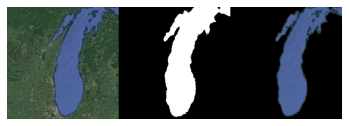

i= 38 loss= 0.14142334177380517 val_loss= 0.17005276679992676 dice_coef= 0.85857666 val_dice_coef= 0.8299472
255.0


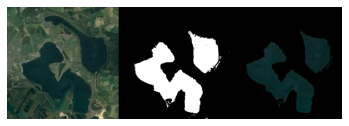

i= 39 loss= 0.21062823988142468 val_loss= 0.11302793025970459 dice_coef= 0.7893718 val_dice_coef= 0.88697207
255.0


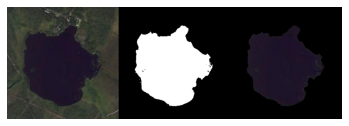

i= 40 loss= 0.10977036612374443 val_loss= 0.15809387394360133 dice_coef= 0.8902297 val_dice_coef= 0.84190613
255.0


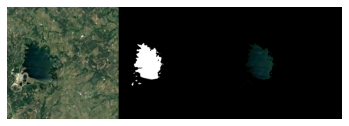

i= 41 loss= 0.07601480256943476 val_loss= 0.34872984886169434 dice_coef= 0.92398506 val_dice_coef= 0.6512701
255.0


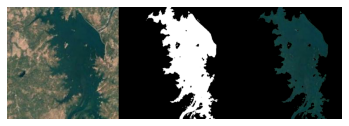

i= 42 loss= 0.0971486284619286 val_loss= 0.19571638533047267 dice_coef= 0.9028513 val_dice_coef= 0.8042836
255.0


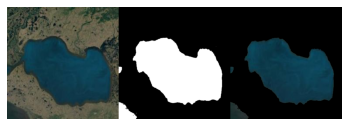

i= 43 loss= 0.1038525416737511 val_loss= 0.157241267817361 dice_coef= 0.8961473 val_dice_coef= 0.8427588
255.0


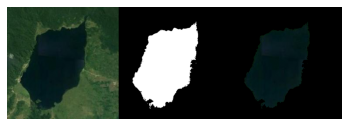


Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.
i= 44 loss= 0.18301055544898623 val_loss= 0.21447224702153886 dice_coef= 0.81698954 val_dice_coef= 0.7855277
255.0


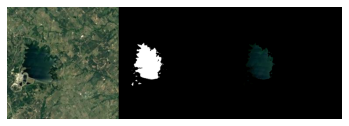

i= 45 loss= 0.09605095500037783 val_loss= 0.16492803181920732 dice_coef= 0.903949 val_dice_coef= 0.835072
255.0


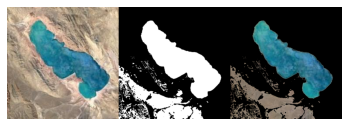

i= 46 loss= 0.1265592546690078 val_loss= 0.1302949743611472 dice_coef= 0.8734407 val_dice_coef= 0.869705
255.0


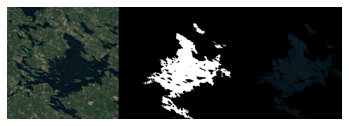

i= 47 loss= 0.1632659804253351 val_loss= 0.14681342244148254 dice_coef= 0.83673394 val_dice_coef= 0.8531865
252.70282


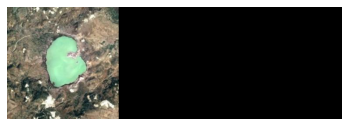

i= 48 loss= 0.1103235539935884 val_loss= 0.2577717048781259 dice_coef= 0.88967633 val_dice_coef= 0.7422283
255.0


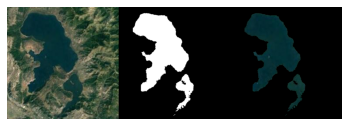

i= 49 loss= 0.11195260002499535 val_loss= 0.16007286735943385 dice_coef= 0.88804734 val_dice_coef= 0.8399272
255.0


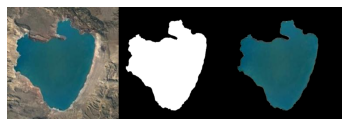

i= 50 loss= 0.22827781098229544 val_loss= 0.1051644470010485 dice_coef= 0.77172226 val_dice_coef= 0.89483553
162.86815


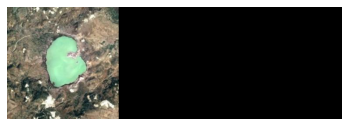

i= 51 loss= 0.14856481552124023 val_loss= 0.1979666522571019 dice_coef= 0.85143524 val_dice_coef= 0.8020333
255.0


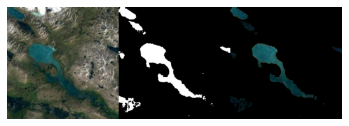

i= 52 loss= 0.10236310107367379 val_loss= 0.3354172876902989 dice_coef= 0.8976369 val_dice_coef= 0.6645827
255.0


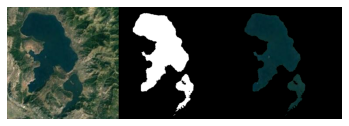

i= 53 loss= 0.15414272035871232 val_loss= 0.12845941100801742 dice_coef= 0.8458573 val_dice_coef= 0.8715406
255.0


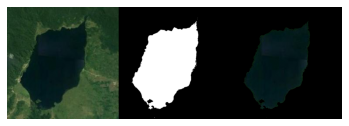

i= 54 loss= 0.10984501100721814 val_loss= 0.15661245584487915 dice_coef= 0.89015496 val_dice_coef= 0.84338754
255.0


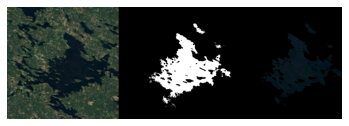


Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.
i= 55 loss= 0.10302107674734932 val_loss= 0.1285353430679866 dice_coef= 0.8969789 val_dice_coef= 0.8714646
33.772263


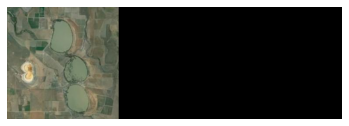

i= 56 loss= 0.21910627115340459 val_loss= 0.10649605734007699 dice_coef= 0.78089386 val_dice_coef= 0.893504
255.0


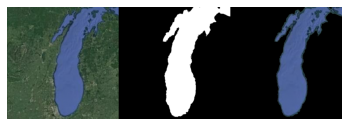

i= 57 loss= 0.12448848145348686 val_loss= 0.10339963861874171 dice_coef= 0.87551147 val_dice_coef= 0.8966003
255.0


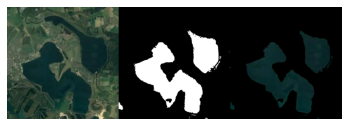

i= 58 loss= 0.12315807739893596 val_loss= 0.17969557642936707 dice_coef= 0.87684196 val_dice_coef= 0.8203044
255.0


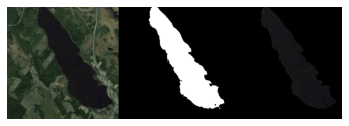

i= 59 loss= 0.14036053986776442 val_loss= 0.11074900201388768 dice_coef= 0.85963947 val_dice_coef= 0.88925093
255.0


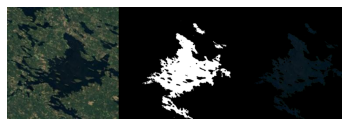

i= 60 loss= 0.17614242292585827 val_loss= 0.18154322249548777 dice_coef= 0.82385755 val_dice_coef= 0.81845695
255.0


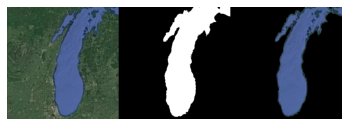

i= 61 loss= 0.08639778977348692 val_loss= 0.18291800362723215 dice_coef= 0.9136021 val_dice_coef= 0.817082
255.0


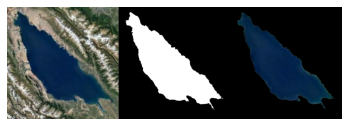

i= 62 loss= 0.1337873935699463 val_loss= 0.2442234115941184 dice_coef= 0.86621267 val_dice_coef= 0.7557765
255.0


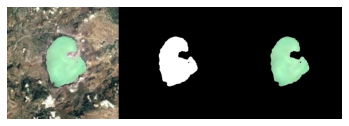

i= 63 loss= 0.12894006002516972 val_loss= 0.27287019576345173 dice_coef= 0.8710599 val_dice_coef= 0.7271299
255.0


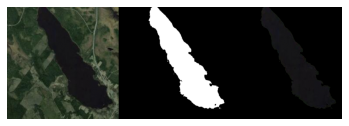


Epoch 00064: ReduceLROnPlateau reducing learning rate to 0.0002621440216898918.
i= 64 loss= 0.09698096911112468 val_loss= 0.20772395815168107 dice_coef= 0.90301895 val_dice_coef= 0.792276
255.0


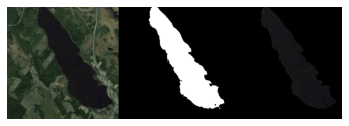

i= 65 loss= 0.11065037477584112 val_loss= 0.25485546248299734 dice_coef= 0.8893495 val_dice_coef= 0.74514455
255.0


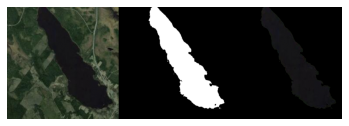

i= 66 loss= 0.09378083830788023 val_loss= 0.10738053066389901 dice_coef= 0.9062191 val_dice_coef= 0.8926195
255.0


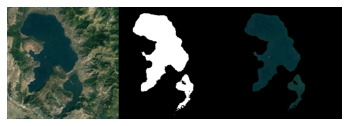

i= 67 loss= 0.09516690458570208 val_loss= 0.19980253066335404 dice_coef= 0.90483314 val_dice_coef= 0.8001975
255.0


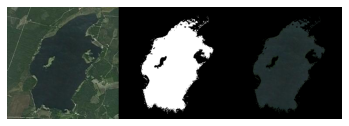

i= 68 loss= 0.12019461109524682 val_loss= 0.19901661361966813 dice_coef= 0.87980545 val_dice_coef= 0.8009834
255.0


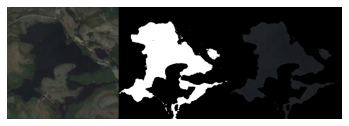

i= 69 loss= 0.16386210918426514 val_loss= 0.1821783951350621 dice_coef= 0.8361379 val_dice_coef= 0.8178215
255.0


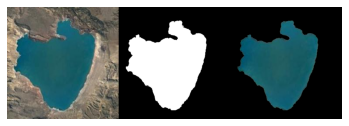

i= 70 loss= 0.21457862570172265 val_loss= 0.12975900513785227 dice_coef= 0.7854214 val_dice_coef= 0.870241
255.0


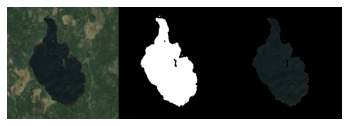

i= 71 loss= 0.0685914641334897 val_loss= 0.1417686172894069 dice_coef= 0.93140846 val_dice_coef= 0.85823125
255.0


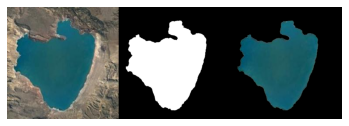

i= 72 loss= 0.07452435720534552 val_loss= 0.204539316041129 dice_coef= 0.9254756 val_dice_coef= 0.7954607
255.0


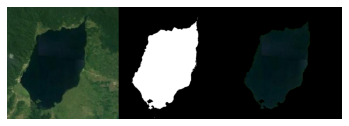


Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.00020971521735191345.
i= 73 loss= 0.1366038890112014 val_loss= 0.18524711472647531 dice_coef= 0.86339605 val_dice_coef= 0.81475294
255.0


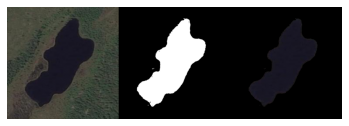

i= 74 loss= 0.10025529918216523 val_loss= 0.21886438982827322 dice_coef= 0.89974475 val_dice_coef= 0.7811356
255.0


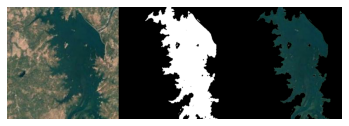

i= 75 loss= 0.07265765894026983 val_loss= 0.10456444535936628 dice_coef= 0.9273425 val_dice_coef= 0.8954355
255.0


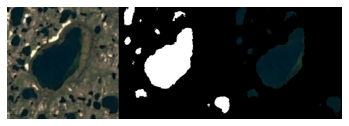

i= 76 loss= 0.10008955001831055 val_loss= 0.1194430376802172 dice_coef= 0.8999105 val_dice_coef= 0.88055694
0.1853396


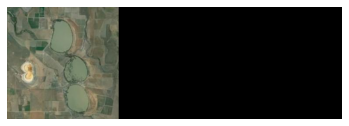

i= 77 loss= 0.08110536847795759 val_loss= 0.22518296326909745 dice_coef= 0.91889465 val_dice_coef= 0.77481705
255.0


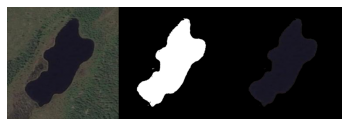

i= 78 loss= 0.06775158359890893 val_loss= 0.1668153362614768 dice_coef= 0.93224835 val_dice_coef= 0.8331846
255.0


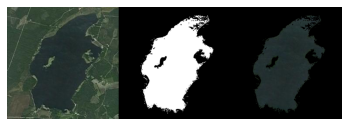

i= 79 loss= 0.0697854615393139 val_loss= 0.24486288854054042 dice_coef= 0.9302146 val_dice_coef= 0.75513715
255.0


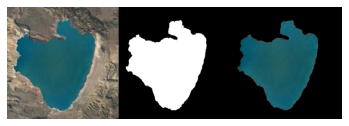

i= 80 loss= 0.06504233678181966 val_loss= 0.17730309707777842 dice_coef= 0.9349577 val_dice_coef= 0.8226968
255.0


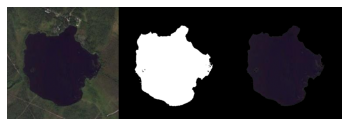

i= 81 loss= 0.070158927213578 val_loss= 0.15550036941255843 dice_coef= 0.929841 val_dice_coef= 0.8444997
255.0


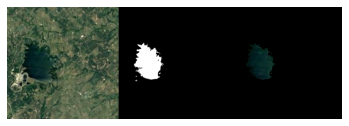


Epoch 00082: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.
i= 82 loss= 0.11068004937399001 val_loss= 0.11599812337330409 dice_coef= 0.88932 val_dice_coef= 0.88400185
255.0


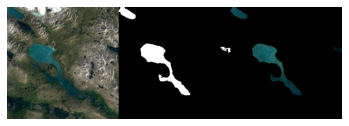

i= 83 loss= 0.13994247288930983 val_loss= 0.12193067158971514 dice_coef= 0.8600575 val_dice_coef= 0.87806934
255.0


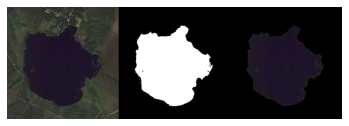

i= 84 loss= 0.12943834350222633 val_loss= 0.164652624300548 dice_coef= 0.8705617 val_dice_coef= 0.8353473
255.0


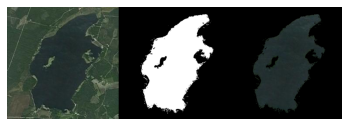

i= 85 loss= 0.12870806739443824 val_loss= 0.09569277933665685 dice_coef= 0.87129194 val_dice_coef= 0.90430725
255.0


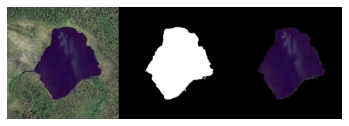

i= 86 loss= 0.10894639151436943 val_loss= 0.19787615537643433 dice_coef= 0.8910537 val_dice_coef= 0.8021239
255.0


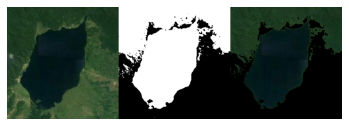

i= 87 loss= 0.11647400685719081 val_loss= 0.1252220060144152 dice_coef= 0.883526 val_dice_coef= 0.8747779
255.0


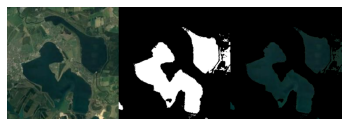

i= 88 loss= 0.09851222378867013 val_loss= 0.15959898488862173 dice_coef= 0.90148765 val_dice_coef= 0.8404011
254.69319


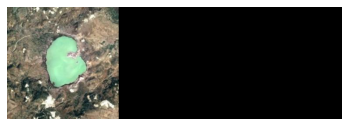

i= 89 loss= 0.13019136587778726 val_loss= 0.15100136399269104 dice_coef= 0.86980855 val_dice_coef= 0.8489986
255.0


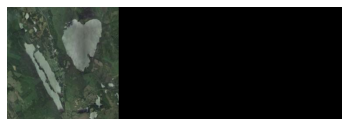

i= 90 loss= 0.07229240451540266 val_loss= 0.1763953992298671 dice_coef= 0.9277075 val_dice_coef= 0.82360464
255.0


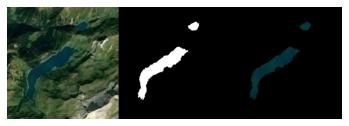


Epoch 00091: ReduceLROnPlateau reducing learning rate to 0.00013421773910522462.
i= 91 loss= 0.04581902140662784 val_loss= 0.23147137675966536 dice_coef= 0.954181 val_dice_coef= 0.76852864
255.0


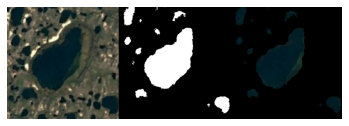

i= 92 loss= 0.0712051930881682 val_loss= 0.11273114170346941 dice_coef= 0.92879486 val_dice_coef= 0.8872689
255.0


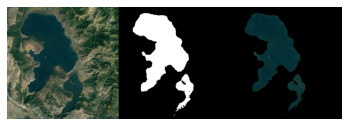

i= 93 loss= 0.05622413612547375 val_loss= 0.12883735128811427 dice_coef= 0.94377583 val_dice_coef= 0.8711627
255.0


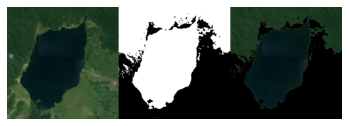

i= 94 loss= 0.06879035631815593 val_loss= 0.14809881363596236 dice_coef= 0.9312097 val_dice_coef= 0.8519012
255.0


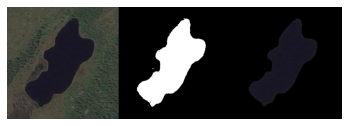

i= 95 loss= 0.1076132201013111 val_loss= 0.09335194740976606 dice_coef= 0.89238685 val_dice_coef= 0.9066481
255.0


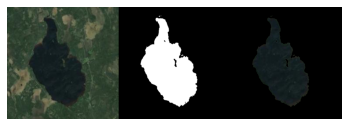

i= 96 loss= 0.10919030507405598 val_loss= 0.16139242478779384 dice_coef= 0.8908097 val_dice_coef= 0.8386075
255.0


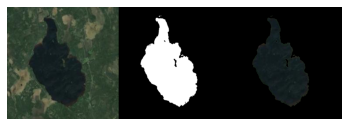

i= 97 loss= 0.09746088868095762 val_loss= 0.2469932096345084 dice_coef= 0.90253913 val_dice_coef= 0.7530068
255.0


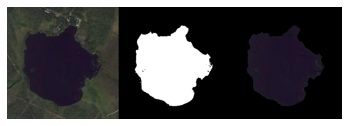

i= 98 loss= 0.10309593450455438 val_loss= 0.21738705464771815 dice_coef= 0.8969041 val_dice_coef= 0.78261286
255.0


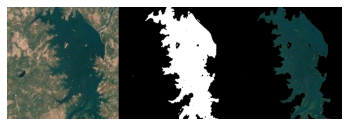

i= 99 loss= 0.09113499096461705 val_loss= 0.09952854684420995 dice_coef= 0.9088651 val_dice_coef= 0.9004715
255.0


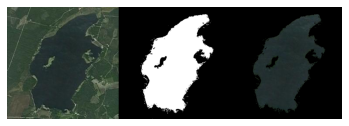


Epoch 00100: ReduceLROnPlateau reducing learning rate to 0.00010737419361248613.
i= 100 loss= 0.07769543216342017 val_loss= 0.17298986230577743 dice_coef= 0.9223045 val_dice_coef= 0.82701015
255.0


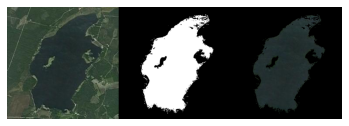

In [10]:
# a tolerance for the training.
min_delta = 0.0001

# minimum learning rate (lambda)
min_lr = 0.0001

# the factor applied to the learning rate when the appropriate triggers are made
factor = 0.8

prop_train = 0.6

all_files = os.listdir('nwpu_images/data')
shuffle(all_files)

split = int(prop_train * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

batch_size = 2

filepath = 'res_dice_crf_unet_bs_'+str(batch_size)+'.h5'

train_generator = image_batch_generator(train_files, batch_size = batch_size)
test_generator  = image_batch_generator(test_files, batch_size = batch_size)

train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
print(train_steps)
print(test_steps)

res_dice_history = model.fit(train_generator, 
                    epochs = 100, steps_per_epoch = train_steps,
                    validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(filepath, min_delta, min_lr, factor), verbose = 0,
                    use_multiprocessing=False)  #True

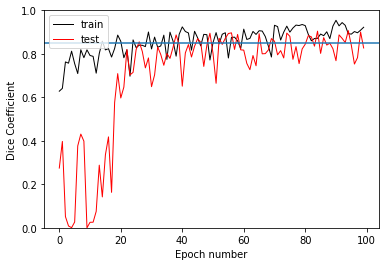

In [11]:
plt.plot(res_dice_history.history['dice_coef'],'k',lw=1)
plt.plot(res_dice_history.history['val_dice_coef'],'r',lw=1)
plt.ylim(0,1)
plt.axhline(y=0.85)
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch number')
plt.legend(['train', 'test'], loc='upper left')

plt.show()